In [1]:
from collections import namedtuple

import numpy as np

import jax
import jax.numpy as jnp
import jax.nn as jnn

jax.config.update('jax_platform_name', 'cpu')

import crayopt

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
SEED = 112233
rng = jax.random.PRNGKey(SEED)

In [3]:
MU1 = jnp.array([0.0, -1.0])
MU2 = jnp.array([0.0, 1.0])

A1 = jnp.array([
    [1.0, 0.0],
    [0.0, 1.0],
])

A2 = jnp.array([
    [0.5, 0.0],
    [0.0, 0.5],
])

def sample_data(key: jax.Array, n: int):
    key_pos, key_neg = jax.random.split(key, num=2) 

    x_pos = jax.random.normal(key_pos, shape=(n, 2)) @ A1 + MU1
    x_neg = jax.random.normal(key_neg, shape=(n, 2)) @ A2 + MU2

    y_pos = jnp.ones(shape=(n, ))
    y_neg = jnp.zeros(shape=(n, ))
    
    return jnp.concatenate([x_pos, x_neg], axis=0), jnp.concatenate([y_pos, y_neg])

In [4]:
X, y = sample_data(rng, 128)

In [5]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], color=plt.cm.tab10(0))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color=plt.cm.tab10(1))

In [6]:
Parameters = namedtuple('Parameters', ['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])

def nn(xs, parameters):
    W1, b1, W2, b2, W3, b3 = parameters
    
    if W1.ndim == 3:
        b1 = b1[:, None, :]
        b2 = b2[:, None, :]
        b3 = b3[:, None, :]

    h1 = jnn.softplus(jnp.matmul(xs, W1) + b1)
    h2 = jnn.softplus(jnp.matmul(h1, W2) + b2)
    h3 = jnp.matmul(h2, W3) + b3
    
    return h3.reshape(h3.shape[:-1])

In [7]:
shapes = Parameters((2, 16), (16, ), (16, 32), (32, ), (32, 1), (1, ))

def init(key):
    key_W1, key_W2, key_W3 = jax.random.split(key, num=3)
    return Parameters(
        W1=jax.random.normal(key_W1, shape=shapes.W1),
        W2=jax.random.normal(key_W2, shape=shapes.W2),
        W3=0.25 * jax.random.normal(key_W3, shape=shapes.W3),
        b1=jnp.zeros(shape=shapes.b1),
        b2=jnp.zeros(shape=shapes.b2),
        b3=jnp.zeros(shape=shapes.b3),
    )

In [8]:
key_xs, key_init = jax.random.split(rng, num=2)
xs, _ = sample_data(key_xs, n=8)
nn(xs, init(key_init))

Array([5.582387 , 4.5623174, 5.851521 , 7.734556 , 6.010571 , 9.970583 ,
       6.168192 , 5.871427 , 5.0561457, 6.0860357, 7.4893694, 5.987507 ,
       4.366119 , 5.70383  , 6.062099 , 6.57568  ], dtype=float32)

In [9]:
@jax.jit
def target(key, params):
    W1, _, W2, _, W3, _ = params

    xs, ys = sample_data(key, n=4)

    ps = nn(xs, params)
    loss = ys * jax.nn.softplus(-ps) + (1 - ys) * jax.nn.softplus(ps)
    
    reg = jnp.sum(jnp.square(W1), axis=(1, 2)) + \
          jnp.sum(jnp.square(W2), axis=(1, 2)) + \
          jnp.sum(jnp.square(W3), axis=(1, 2))
    
    return jnp.mean(loss, ) + 1e-3 * reg

In [10]:
n_batch = 4

optimizers = dict(
    ses=crayopt.SES(initial_sigma=1e-2, gradient=crayopt.adam(learning_rate=1e-3)),
    snes=crayopt.SNES(learning_rate=1e-1, sigma0=1e-2, rho=0.9, learning_rate_sigma=0.1),
    fastlinlax=crayopt.FastLinLAX(
        sigma=1e-2,
        gradient=crayopt.adam(learning_rate=1e-3, beta1=0.9, beta2=0.95),
        alpha=1
    ),
    lingrad=crayopt.LinGrad(
        sigma=1e-2,
        gradient=crayopt.adamax(learning_rate=1e-3, beta1=0.9, beta2=0.95),
        alpha=1
    ),
    quadgrad=crayopt.QuadGrad(
        sigma=1e-2,
        gradient=crayopt.adamax(learning_rate=1e-3, beta1=0.9, beta2=0.95),
        alpha=1
    ),
    uadam=crayopt.uadam(learning_rate=1.0e-3),
    ortho_adam=crayopt.uadam(learning_rate=1.0e-3, alpha=None, scale=1.0e-3),
)

def get_step(optimizer):
    def step(key, state):
        key_propose, key_target = jax.random.split(key, num=2)
        
        proposal = optimizer.propose(key_propose, state, batch=(n_batch, ))
        value = target(key_target, proposal)
        return value, *optimizer(proposal, value, state)

    return step
        

steps = {
    name: jax.jit(get_step(opt))
    for name, opt in optimizers.items()
}

In [11]:
baseline_optimizer = crayopt.adam(learning_rate=1e-2)

@jax.jit
def step_baseline(key, parameters, state):
    def target_(key, params):
        key_params, key_target = jax.random.split(key, num=2)

        params_ = jax.tree_util.tree_map(lambda x: x[None], params)
        
        return jnp.mean(target(key_target, params_))

    value, grad = jax.value_and_grad(target_, argnums=1)(key, parameters)
    
    return value, *baseline_optimizer(parameters, grad, state)

In [12]:
n_trials = 1
n = 32 * 1024

trial_rng = jax.random.PRNGKey(122222)


initial_ps = [
    init(key)
    for key in jax.random.split(trial_rng, num=n_trials)
]

solutions = {
    name: list()
    for name in optimizers
}

traces = {
    name: np.ndarray(shape=(n_trials, n, n_batch))
    for name in optimizers
}

for name, step in steps.items():
    rng = trial_rng

    for i in tqdm(range(n_trials), desc=name):
        state = optimizers[name].initial_state(initial_ps[i])
        parameters = initial_ps[i]
    
        for j in range(n):
            rng, key = jax.random.split(rng, num=2)
            traces[name][i, j], parameters, state = step(key, state)
        
        solutions[name].append(parameters)

ses:   0%|          | 0/1 [00:00<?, ?it/s]

snes:   0%|          | 0/1 [00:00<?, ?it/s]

fastlinlax:   0%|          | 0/1 [00:00<?, ?it/s]

lingrad:   0%|          | 0/1 [00:00<?, ?it/s]

quadgrad:   0%|          | 0/1 [00:00<?, ?it/s]

uadam:   0%|          | 0/1 [00:00<?, ?it/s]

ortho_adam:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
name = 'baseline'
traces[name] = np.ndarray(shape=(n_trials, n, n_batch))
solutions[name] = list()

rng = trial_rng

for i in tqdm(range(n_trials), desc=name):
    parameters = initial_ps[i]
    state = baseline_optimizer.initial_state(parameters)

    for j in range(n):
        rng, key = jax.random.split(rng, num=2)
        traces[name][i, j], parameters, state = step_baseline(key, parameters, state)

    solutions[name].append(parameters)

baseline:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
plt.figure(figsize=(12, 9))

from scipy.signal import convolve

for i, (name, trace) in enumerate(traces.items()):
    smoothed = convolve(trace, np.ones(shape=(1, 32, 1)) / 32, mode='valid')
    ys = jnp.mean(smoothed, axis=-1)
    ys_median = np.median(ys, axis=0)
    ys_lower = np.quantile(ys, q=0.1, axis=0)
    ys_upper = np.quantile(ys, q=0.9, axis=0)
    xs = np.arange(ys.shape[1])
    
    plt.plot(xs, ys_median, color=plt.cm.tab10(i), label=name)
    plt.fill_between(xs, ys_lower, ys_upper, alpha=0.25, color=plt.cm.tab10(i), )

plt.legend()
plt.yscale('log')

In [15]:
grid_xs = jnp.linspace(-1, 1, num=31)
grid_ys = jnp.linspace(-1, 1, num=33)
Xs = jnp.stack([
    x
    for x in jnp.meshgrid(grid_xs, grid_ys, indexing='ij')
], axis=-1)

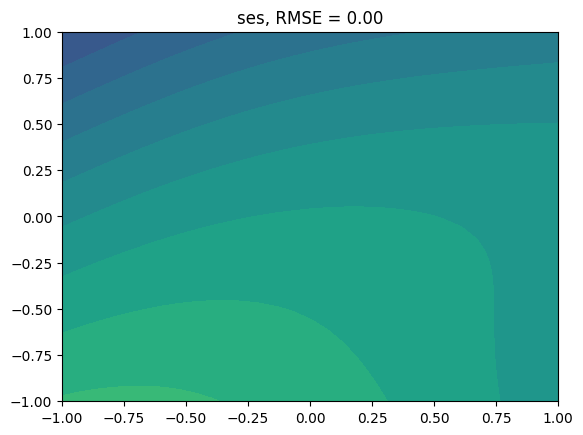

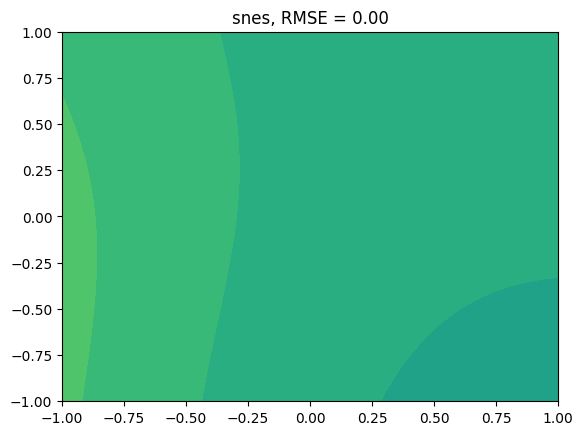

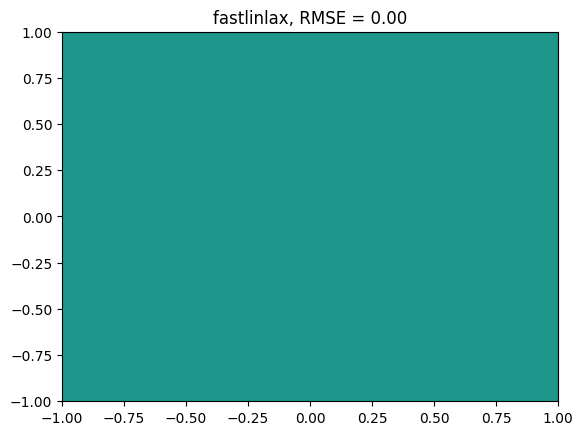

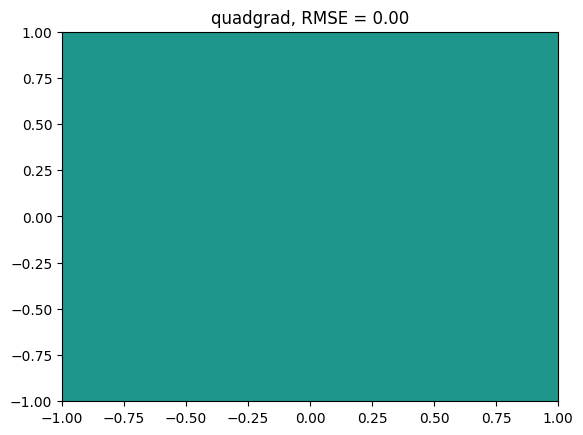

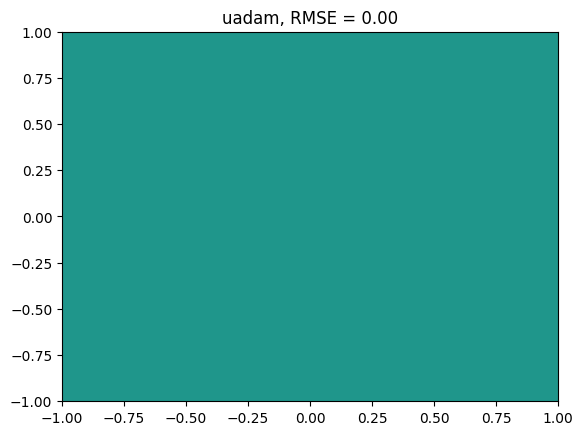

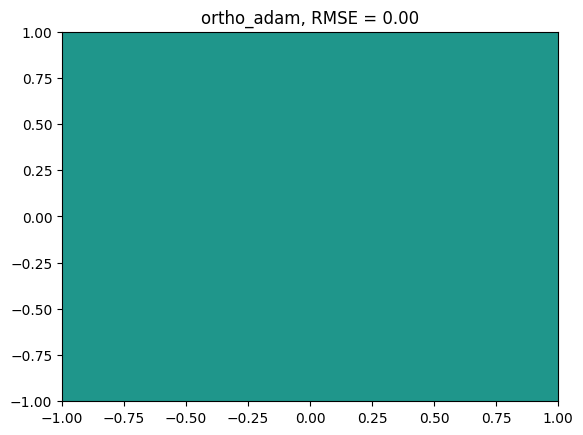

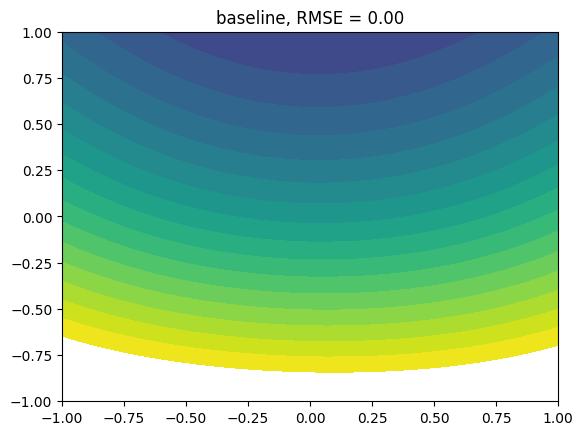

In [16]:
for name in solutions:
    ps = nn(Xs.reshape(-1, 2), solutions[name][0]).reshape(Xs.shape[:-1])
    
    # rmse = jnp.sqrt(jnp.mean(jnp.square(Ys - ps)))
    
    plt.figure()
    plt.title('%s, RMSE = %.2lf' % (name, 0.0, ))
    plt.contourf(grid_xs, grid_ys, ps.T, levels=np.linspace(-5, 5, num=21))
    plt.show()